In [7]:
# Weather 회귀 모델 (Rainfall 예측) - RainTomorrow 삭제
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

# PyTorch imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn import functional as F
import torch.nn.init as init

# 데이터 로드 함수 (회귀용)
def load_weather_data_regression(file_path):
    """Weather 데이터셋을 로드하는 함수 (회귀용)"""
    df = pd.read_csv(file_path)
    return df

# 데이터 전처리 함수 (회귀용) - RainTomorrow 삭제, Rainfall을 타겟으로 설정
def preprocess_weather_data_regression(df):
    """Weather 데이터 전처리를 수행하는 함수 (회귀용)"""
    print("=== Data Preprocessing for Regression ===")
    print(f"Original data shape: {df.shape}")
    
    # 결측값 확인
    print("\nMissing values check:")
    missing_values = df.isnull().sum()
    print(missing_values[missing_values > 0])
    
    # 'NA' 값을 NaN으로 변환
    df = df.replace('NA', np.nan)
    
    # 숫자형 컬럼의 결측값을 평균으로 채우기
    numeric_columns = df.select_dtypes(include=[np.number]).columns
    for col in numeric_columns:
        if df[col].isnull().sum() > 0:
            df[col].fillna(df[col].mean(), inplace=True)
    
    # 범주형 컬럼의 결측값을 최빈값으로 채우기
    categorical_columns = df.select_dtypes(include=['object']).columns
    for col in categorical_columns:
        if df[col].isnull().sum() > 0:
            df[col].fillna(df[col].mode()[0], inplace=True)
    
    # 불필요한 컬럼 제거 (Date, Location, RISK_MM, RainTomorrow)
    df = df.drop(['Date', 'Location', 'RISK_MM', 'RainTomorrow'], axis=1, errors='ignore')
    
    # 범주형 변수 인코딩
    le_dict = {}
    for col in df.select_dtypes(include=['object']).columns:
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col].astype(str))
        le_dict[col] = le
    
    # 특성과 타겟 분리 (Rainfall이 타겟)
    X = df.drop('Rainfall', axis=1)
    y = df['Rainfall']
    
    print(f"\nAfter preprocessing:")
    print(f"Features shape: {X.shape}")
    print(f"Target shape: {y.shape}")
    print(f"Target statistics:")
    print(f"  Mean: {y.mean():.3f}")
    print(f"  Std: {y.std():.3f}")
    print(f"  Min: {y.min():.3f}")
    print(f"  Max: {y.max():.3f}")
    
    return X, y, le_dict

# 데이터 탐색 함수 (회귀용)
def explore_weather_data_regression(df):
    """Weather 데이터 탐색을 수행하는 함수 (회귀용)"""
    print("=== Weather Dataset Basic Information (Regression) ===")
    print(f"Data shape: {df.shape}")
    print(f"Columns: {list(df.columns)}")
    
    print("\n=== Target (Rainfall) Distribution ===")
    print(f"Rainfall statistics:")
    print(f"  Mean: {df['Rainfall'].mean():.3f}")
    print(f"  Median: {df['Rainfall'].median():.3f}")
    print(f"  Std: {df['Rainfall'].std():.3f}")
    print(f"  Min: {df['Rainfall'].min():.3f}")
    print(f"  Max: {df['Rainfall'].max():.3f}")
    
    print("\n=== Basic Statistics ===")
    print(df.describe())
    
    print("\n=== Missing Values ===")
    missing_values = df.isnull().sum()
    print(missing_values[missing_values > 0])
    
    return df


In [8]:
# PyTorch 회귀 모델 정의
class WeatherMLPRegressor(nn.Module):
    """Weather 예측을 위한 다층 퍼셉트론 회귀기"""
    def __init__(self, input_size, hidden_sizes=[256, 128, 64, 32], dropout_rate=0.3):
        super(WeatherMLPRegressor, self).__init__()
        
        layers = []
        prev_size = input_size
        
        for hidden_size in hidden_sizes:
            layers.extend([
                nn.Linear(prev_size, hidden_size),
                nn.BatchNorm1d(hidden_size),
                nn.ReLU(),
                nn.Dropout(dropout_rate)
            ])
            prev_size = hidden_size
        
        layers.append(nn.Linear(prev_size, 1))  # 회귀는 출력이 1개
        self.network = nn.Sequential(*layers)
        
        # 가중치 초기화
        self.apply(self._init_weights)
    
    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            init.xavier_uniform_(m.weight)
            init.constant_(m.bias, 0)
    
    def forward(self, x):
        return self.network(x).squeeze()  # 차원 축소

class WeatherCNNRegressor(nn.Module):
    """Weather 예측을 위한 1D CNN 회귀기"""
    def __init__(self, input_size, dropout_rate=0.3):
        super(WeatherCNNRegressor, self).__init__()
        
        # 1D CNN layers
        self.conv1 = nn.Conv1d(1, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(64, 128, kernel_size=3, padding=1)
        self.conv3 = nn.Conv1d(128, 256, kernel_size=3, padding=1)
        
        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(128)
        self.bn3 = nn.BatchNorm1d(256)
        
        self.pool = nn.AdaptiveAvgPool1d(1)
        self.dropout = nn.Dropout(dropout_rate)
        
        # Fully connected layers
        self.fc1 = nn.Linear(256, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)  # 회귀는 출력이 1개
        
    def forward(self, x):
        # x shape: (batch_size, input_size) -> (batch_size, 1, input_size)
        x = x.unsqueeze(1)
        
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.dropout(x)
        
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.dropout(x)
        
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.pool(x)
        
        # Flatten
        x = x.view(x.size(0), -1)
        
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        
        return x.squeeze()  # 차원 축소

class WeatherLSTMRegressor(nn.Module):
    """Weather 예측을 위한 LSTM 회귀기"""
    def __init__(self, input_size, hidden_size=128, num_layers=3, dropout_rate=0.3):
        super(WeatherLSTMRegressor, self).__init__()
        
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, 
                           batch_first=True, dropout=dropout_rate if num_layers > 1 else 0)
        self.dropout = nn.Dropout(dropout_rate)
        
        # Attention mechanism
        self.attention = nn.MultiheadAttention(hidden_size, num_heads=8, dropout=dropout_rate)
        
        self.fc1 = nn.Linear(hidden_size, 64)
        self.fc2 = nn.Linear(64, 1)  # 회귀는 출력이 1개
        
    def forward(self, x):
        # x shape: (batch_size, input_size) -> (batch_size, 1, input_size)
        x = x.unsqueeze(1)
        
        # LSTM forward pass
        lstm_out, _ = self.lstm(x)
        
        # Self-attention
        attn_output, _ = self.attention(lstm_out, lstm_out, lstm_out)
        
        # Global average pooling
        output = attn_output.mean(dim=1)
        output = self.dropout(output)
        
        output = F.relu(self.fc1(output))
        output = self.dropout(output)
        output = self.fc2(output)
        
        return output.squeeze()  # 차원 축소

# PyTorch 데이터셋 클래스 (회귀용)
class WeatherRegressionDataset(Dataset):
    """Weather 회귀 데이터셋을 위한 PyTorch Dataset"""
    def __init__(self, features, targets):
        self.features = torch.FloatTensor(features)
        self.targets = torch.FloatTensor(targets)
    
    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, idx):
        return self.features[idx], self.targets[idx]

# PyTorch 회귀 모델들을 정의하는 함수
def get_weather_pytorch_regressors(input_size):
    """다양한 Weather PyTorch 회귀 모델들을 반환하는 함수"""
    models = {
        'MLP': WeatherMLPRegressor(input_size, [256, 128, 64, 32]),
        'CNN': WeatherCNNRegressor(input_size),
        'LSTM': WeatherLSTMRegressor(input_size, 128, 3)
    }
    return models


In [9]:
# PyTorch 회귀 모델 훈련 함수
def train_weather_regressor(model, train_loader, val_loader, num_epochs=150, learning_rate=0.001, device='cpu'):
    """Weather PyTorch 회귀 모델을 훈련하는 함수"""
    model = model.to(device)
    criterion = nn.MSELoss()  # 회귀는 MSE Loss 사용
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=15, factor=0.5)
    
    train_losses = []
    val_losses = []
    train_maes = []
    val_maes = []
    
    best_val_loss = float('inf')
    best_model_state = None
    patience_counter = 0
    early_stopping_patience = 30
    
    for epoch in range(num_epochs):
        # 훈련 모드
        model.train()
        train_loss = 0
        train_mae = 0
        train_total = 0
        
        for batch_features, batch_targets in train_loader:
            batch_features, batch_targets = batch_features.to(device), batch_targets.to(device)
            
            optimizer.zero_grad()
            outputs = model(batch_features)
            loss = criterion(outputs, batch_targets)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            train_mae += F.l1_loss(outputs, batch_targets).item()
            train_total += batch_targets.size(0)
        
        # 검증 모드
        model.eval()
        val_loss = 0
        val_mae = 0
        val_total = 0
        
        with torch.no_grad():
            for batch_features, batch_targets in val_loader:
                batch_features, batch_targets = batch_features.to(device), batch_targets.to(device)
                outputs = model(batch_features)
                loss = criterion(outputs, batch_targets)
                
                val_loss += loss.item()
                val_mae += F.l1_loss(outputs, batch_targets).item()
                val_total += batch_targets.size(0)
        
        # 평균 계산
        avg_train_loss = train_loss / len(train_loader)
        avg_val_loss = val_loss / len(val_loader)
        avg_train_mae = train_mae / len(train_loader)
        avg_val_mae = val_mae / len(val_loader)
        
        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)
        train_maes.append(avg_train_mae)
        val_maes.append(avg_val_mae)
        
        # 학습률 스케줄링
        scheduler.step(avg_val_loss)
        
        # 최고 성능 모델 저장
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_model_state = model.state_dict().copy()
            patience_counter = 0
        else:
            patience_counter += 1
        
        # Early stopping
        if patience_counter >= early_stopping_patience:
            print(f"Early stopping at epoch {epoch+1}")
            break
        
        # 진행 상황 출력 (20 에포크마다)
        if (epoch + 1) % 20 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], '
                  f'Train Loss: {avg_train_loss:.4f}, Train MAE: {avg_train_mae:.4f}, '
                  f'Val Loss: {avg_val_loss:.4f}, Val MAE: {avg_val_mae:.4f}')
    
    # 최고 성능 모델 로드
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
    
    return {
        'model': model,
        'train_losses': train_losses,
        'val_losses': val_losses,
        'train_maes': train_maes,
        'val_maes': val_maes,
        'best_val_loss': best_val_loss
    }

# PyTorch 회귀 모델 평가 함수
def evaluate_weather_regressor(model, test_loader, device='cpu'):
    """Weather PyTorch 회귀 모델을 평가하는 함수"""
    model.eval()
    all_predictions = []
    all_targets = []
    
    with torch.no_grad():
        for batch_features, batch_targets in test_loader:
            batch_features, batch_targets = batch_features.to(device), batch_targets.to(device)
            outputs = model(batch_features)
            
            all_predictions.extend(outputs.cpu().numpy())
            all_targets.extend(batch_targets.cpu().numpy())
    
    # 회귀 메트릭 계산
    mse = mean_squared_error(all_targets, all_predictions)
    mae = mean_absolute_error(all_targets, all_predictions)
    r2 = r2_score(all_targets, all_predictions)
    rmse = np.sqrt(mse)
    
    return mse, mae, r2, rmse, all_predictions, all_targets

# PyTorch 회귀 모델들을 학습하고 평가하는 함수
def train_and_evaluate_weather_regressors(X_train, X_val, X_test, y_train, y_val, y_test, models, device='cpu'):
    """Weather PyTorch 회귀 모델들을 학습하고 평가하는 함수"""
    results = {}
    training_histories = {}
    
    print("=== Weather PyTorch Regression Model Performance Evaluation ===")
    print("-" * 80)
    
    # 데이터로더 생성
    train_dataset = WeatherRegressionDataset(X_train, y_train)
    val_dataset = WeatherRegressionDataset(X_val, y_val)
    test_dataset = WeatherRegressionDataset(X_test, y_test)
    
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
    
    for name, model in models.items():
        print(f"\n{name} model training...")
        
        # 모델 훈련
        training_result = train_weather_regressor(model, train_loader, val_loader, device=device)
        training_histories[name] = training_result
        
        # 모델 평가
        mse, mae, r2, rmse, predictions, targets = evaluate_weather_regressor(
            training_result['model'], test_loader, device
        )
        
        results[name] = {
            'mse': mse,
            'mae': mae,
            'r2': r2,
            'rmse': rmse,
            'predictions': predictions,
            'targets': targets
        }
        
        print(f"\n{name} model results:")
        print(f"Test MSE: {mse:.4f}")
        print(f"Test MAE: {mae:.4f}")
        print(f"Test R²: {r2:.4f}")
        print(f"Test RMSE: {rmse:.4f}")
        print(f"Best validation loss: {training_result['best_val_loss']:.4f}")
        print("-" * 80)
    
    return results, training_histories


In [10]:
# 훈련 히스토리 시각화 함수 (회귀용)
def plot_weather_regression_training_history(training_histories):
    """Weather 회귀 훈련 히스토리를 시각화하는 함수"""
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    for i, (name, history) in enumerate(training_histories.items()):
        # Loss 그래프
        axes[0].plot(history['train_losses'], label=f'{name} Train', alpha=0.7)
        axes[0].plot(history['val_losses'], label=f'{name} Val', alpha=0.7)
        axes[0].set_title('Training Loss (MSE)')
        axes[0].set_xlabel('Epoch')
        axes[0].set_ylabel('Loss')
        axes[0].legend()
        axes[0].grid(True)
        
        # MAE 그래프
        axes[1].plot(history['train_maes'], label=f'{name} Train', alpha=0.7)
        axes[1].plot(history['val_maes'], label=f'{name} Val', alpha=0.7)
        axes[1].set_title('Training MAE')
        axes[1].set_xlabel('Epoch')
        axes[1].set_ylabel('MAE')
        axes[1].legend()
        axes[1].grid(True)
    
    plt.tight_layout()
    plt.show()

# 회귀 결과 시각화 함수
def plot_regression_results(results, training_histories):
    """회귀 결과를 시각화하는 함수"""
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    model_names = list(results.keys())
    
    # R² 점수 비교
    r2_scores = [results[name]['r2'] for name in model_names]
    bars = axes[0, 0].bar(model_names, r2_scores, color='lightblue', edgecolor='navy')
    axes[0, 0].set_title('R² Score Comparison')
    axes[0, 0].set_ylabel('R² Score')
    axes[0, 0].set_ylim(0, 1)
    
    for bar, score in zip(bars, r2_scores):
        axes[0, 0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                       f'{score:.3f}', ha='center', va='bottom')
    
    # RMSE 비교
    rmse_scores = [results[name]['rmse'] for name in model_names]
    bars = axes[0, 1].bar(model_names, rmse_scores, color='lightcoral', edgecolor='darkred')
    axes[0, 1].set_title('RMSE Comparison')
    axes[0, 1].set_ylabel('RMSE')
    
    for bar, score in zip(bars, rmse_scores):
        axes[0, 1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1, 
                       f'{score:.3f}', ha='center', va='bottom')
    
    # MAE 비교
    mae_scores = [results[name]['mae'] for name in model_names]
    bars = axes[1, 0].bar(model_names, mae_scores, color='lightgreen', edgecolor='darkgreen')
    axes[1, 0].set_title('MAE Comparison')
    axes[1, 0].set_ylabel('MAE')
    
    for bar, score in zip(bars, mae_scores):
        axes[1, 0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1, 
                       f'{score:.3f}', ha='center', va='bottom')
    
    # 실제 vs 예측 (최고 성능 모델) - numpy 배열로 변환하여 오류 방지
    best_model_name = max(results, key=lambda x: results[x]['r2'])
    targets = np.array(results[best_model_name]['targets'])
    predictions = np.array(results[best_model_name]['predictions'])
    
    axes[1, 1].scatter(targets, predictions, alpha=0.6, color='blue')
    axes[1, 1].plot([targets.min(), targets.max()], [targets.min(), targets.max()], 'r--', lw=2)
    axes[1, 1].set_xlabel('Actual Rainfall')
    axes[1, 1].set_ylabel('Predicted Rainfall')
    axes[1, 1].set_title(f'Actual vs Predicted - {best_model_name}')
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return best_model_name

# 특성 중요도 분석 함수 (회귀용)
def analyze_weather_regression_feature_importance(model, X, y, feature_names, device='cpu'):
    """Weather PyTorch 회귀 모델의 특성 중요도를 분석하는 함수 (그래디언트 기반)"""
    model.eval()
    X_tensor = torch.FloatTensor(X).to(device)
    y_tensor = torch.FloatTensor(y).to(device)
    
    # 그래디언트 계산을 위해 requires_grad=True 설정
    X_tensor.requires_grad_(True)
    
    # Forward pass
    outputs = model(X_tensor)
    loss = F.mse_loss(outputs, y_tensor)
    
    # 그래디언트 계산
    gradients = torch.autograd.grad(loss, X_tensor, create_graph=True)[0]
    
    # 특성별 중요도 (그래디언트의 절댓값 평균)
    feature_importance = torch.abs(gradients).mean(dim=0).cpu().detach().numpy()
    
    # 정규화
    feature_importance = feature_importance / feature_importance.sum()
    
    importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': feature_importance
    }).sort_values('importance', ascending=False)
    
    print("=== Weather Regression Model Feature Importance (Gradient-based) ===")
    print(importance_df.head(15))
    
    # 시각화
    plt.figure(figsize=(12, 8))
    top_features = importance_df.head(15)
    sns.barplot(data=top_features, x='importance', y='feature', palette='viridis')
    plt.title('Top 15 Feature Importance (Gradient-based)')
    plt.xlabel('Importance')
    plt.tight_layout()
    plt.show()
    
    return importance_df


=== Weather Regression Model - Rainfall Prediction ===
RainTomorrow 컬럼을 삭제하고 Rainfall을 예측하는 회귀 모델을 실행합니다.
정확도와 LOSS 그래프만 표시합니다.

Using device: cuda
=== Weather Dataset Basic Information (Regression) ===
Data shape: (366, 24)
Columns: ['Date', 'Location', 'MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustDir', 'WindGustSpeed', 'WindDir9am', 'WindDir3pm', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm', 'RainToday', 'RISK_MM', 'RainTomorrow']

=== Target (Rainfall) Distribution ===
Rainfall statistics:
  Mean: 1.428
  Median: 0.000
  Std: 4.226
  Min: 0.000
  Max: 39.800

=== Basic Statistics ===
          MinTemp     MaxTemp    Rainfall  Evaporation    Sunshine  \
count  366.000000  366.000000  366.000000   366.000000  363.000000   
mean     7.265574   20.550273    1.428415     4.521858    7.909366   
std      6.025800    6.690516    4.225800     2.669383    3.481517   
min     -

/tmp/ipykernel_106377/2062160195.py:42: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].mean(), inplace=True)
/tmp/ipykernel_106377/2062160195.py:48: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', tr

Epoch [40/150], Train Loss: 3.6010, Train MAE: 1.0730, Val Loss: 10.9692, Val MAE: 1.4068
Epoch [60/150], Train Loss: 3.0498, Train MAE: 0.9530, Val Loss: 8.8850, Val MAE: 1.3577
Epoch [80/150], Train Loss: 3.4779, Train MAE: 0.9625, Val Loss: 8.2174, Val MAE: 1.2925
Epoch [100/150], Train Loss: 1.9039, Train MAE: 0.8021, Val Loss: 9.2258, Val MAE: 1.3188
Early stopping at epoch 109

MLP model results:
Test MSE: 30.9849
Test MAE: 1.8273
Test R²: 0.2671
Test RMSE: 5.5664
Best validation loss: 7.6390
--------------------------------------------------------------------------------

CNN model training...
Epoch [20/150], Train Loss: 6.1337, Train MAE: 1.1960, Val Loss: 13.9791, Val MAE: 1.4830
Epoch [40/150], Train Loss: 5.0106, Train MAE: 0.9054, Val Loss: 9.7492, Val MAE: 1.2298
Epoch [60/150], Train Loss: 4.7186, Train MAE: 0.8459, Val Loss: 10.4673, Val MAE: 1.2809
Epoch [80/150], Train Loss: 3.2615, Train MAE: 0.6814, Val Loss: 9.0773, Val MAE: 1.2567
Epoch [100/150], Train Loss: 2.565

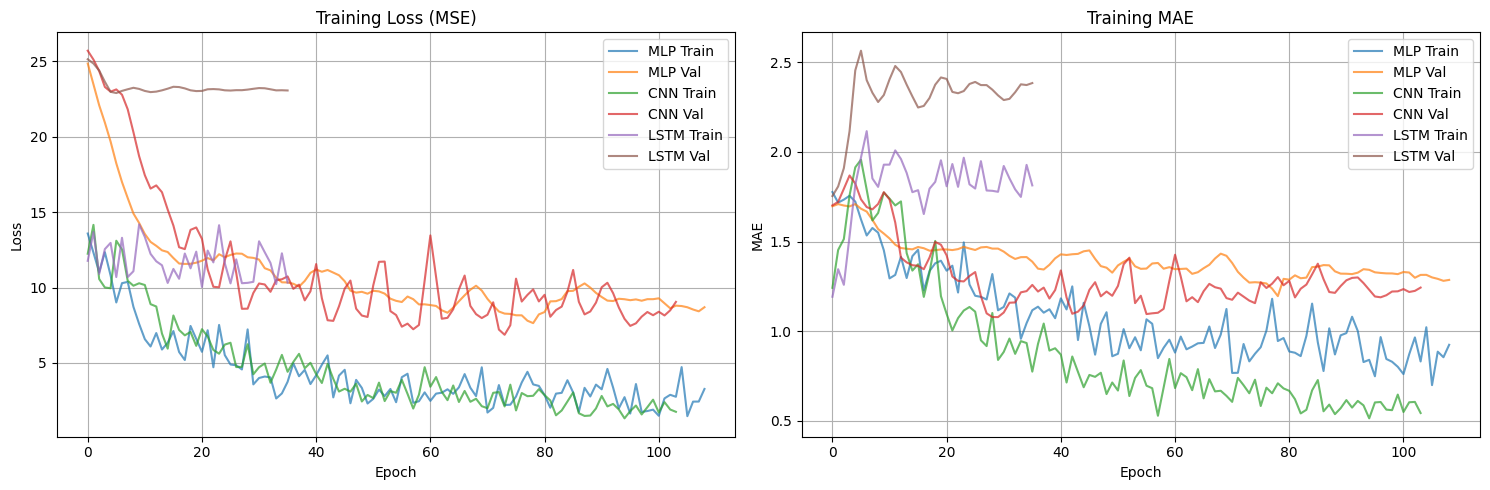


=== Best Performing Weather Regression Model ===
Model: MLP
Test R²: 0.2671
Test RMSE: 5.5664
Test MAE: 1.8273
Best validation loss: 7.6390

=== Prediction Error Analysis ===
Mean absolute error: 1.8273
Median absolute error: 0.1845
Max absolute error: 36.3116
Error std: 5.2579


In [ ]:
# 메인 회귀 실행 함수 
def main_weather_regression():
    """Weather 회귀 메인 함수 - RainTomorrow 삭제, Rainfall 예측"""
    # 디바이스 설정
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    # 데이터 로드
    file_path = 'dataset/weather/weather.csv'
    df = load_weather_data_regression(file_path)
    
    # 데이터 탐색
    explore_weather_data_regression(df)
    
    # 데이터 전처리
    X, y, le_dict = preprocess_weather_data_regression(df)
    
    # 특성 스케일링
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # 데이터 분할 (훈련/검증/테스트)
    X_temp, X_test, y_temp, y_test = train_test_split(
        X_scaled, y, test_size=0.2, random_state=42
    )
    X_train, X_val, y_train, y_val = train_test_split(
        X_temp, y_temp, test_size=0.25, random_state=42
    )
    
    # pandas Series를 numpy array로 변환
    y_train = y_train.values
    y_val = y_val.values
    y_test = y_test.values
    
    print(f"Training set size: {X_train.shape}")
    print(f"Validation set size: {X_val.shape}")
    print(f"Test set size: {X_test.shape}")
    print()
    
    # PyTorch 회귀 모델 정의
    input_size = X_train.shape[1]
    models = get_weather_pytorch_regressors(input_size)
    
    # 모델 학습 및 평가
    results, training_histories = train_and_evaluate_weather_regressors(
        X_train, X_val, X_test, y_train, y_val, y_test, models, device
    )
    
    # 훈련 히스토리 시각화 (Loss와 MAE만)
    plot_weather_regression_training_history(training_histories)
    
    # 최고 성능 모델 찾기
    best_model_name = max(results, key=lambda x: results[x]['r2'])
    best_r2 = results[best_model_name]['r2']
    best_rmse = results[best_model_name]['rmse']
    best_mae = results[best_model_name]['mae']
    
    print(f"\n=== Best Performing Weather Regression Model ===")
    print(f"Model: {best_model_name}")
    print(f"Test R²: {best_r2:.4f}")
    print(f"Test RMSE: {best_rmse:.4f}")
    print(f"Test MAE: {best_mae:.4f}")
    print(f"Best validation loss: {training_histories[best_model_name]['best_val_loss']:.4f}")
    
    # 예측 오차 분석 (텍스트만)
    targets = np.array(results[best_model_name]['targets'])
    predictions = np.array(results[best_model_name]['predictions'])
    errors = np.abs(targets - predictions)
    
    print(f"\n=== Prediction Error Analysis ===")
    print(f"Mean absolute error: {np.mean(errors):.4f}")
    print(f"Median absolute error: {np.median(errors):.4f}")
    print(f"Max absolute error: {np.max(errors):.4f}")
    print(f"Error std: {np.std(errors):.4f}")
    
    return results, training_histories

# Weather 회귀 모델 실행 (간소화된 버전)
print("=== Weather Regression Model - Rainfall Prediction ===")
print("RainTomorrow 컬럼을 삭제하고 Rainfall을 예측하는 회귀 모델을 실행합니다.")
print("정확도와 LOSS 그래프만 표시합니다.")
print()

# 회귀 모델 실행
results, training_histories = main_weather_regression()
